# 4 Data wrangling

## 4.1 Imports & Setup

In [1]:
import os
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
# import datetime
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import numpy as np
# from scipy import stats
# import random
import category_encoders as ce
from category_encoders import LeaveOneOutEncoder, TargetEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import model_selection

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from catboost import CatBoostClassifier
import lightgbm as lgb

import time
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE

from tabulate import tabulate
%matplotlib inline

In [2]:
print(os.getcwd())
os.chdir('/Users/liuyang/Desktop/Springboard_Capstone') 
print(os.getcwd())

/Users/liuyang/Desktop/Springboard_Capstone/notebooks
/Users/liuyang/Desktop/Springboard_Capstone


## 4.2 Loda data

In [3]:
df = pd.read_csv('data/train.csv')

In [4]:
df.shape

(18359, 14)

In [5]:
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,23798,city_149,0.689,Male,Has relevent experience,no_enrollment,Graduate,STEM,3,100-500,Pvt Ltd,1,106,0
1,29166,city_83,0.923,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,<10,Funded Startup,1,69,0
2,46,city_16,0.910,NaN,Has relevent experience,no_enrollment,Graduate,STEM,6,50-99,Public Sector,2,4,0
3,18527,city_64,0.666,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,50-99,Pvt Ltd,1,26,0
4,21751,city_100,0.887,NaN,No relevent experience,no_enrollment,Masters,STEM,8,NaN,NaN,2,88,1


| This | is   |
|------|------|
|   a  | table|

In [6]:
# creata a function to calculate unique value count and percentage for the whole dataset
# and check the data type for each column
def data_info(data):
    count = data.nunique(dropna=False)
    va_pct = round(count/(data.shape[0])*100,2)
    nan_p = round(data.isnull().sum()/data.shape[0]*100,2)
    frame = pd.DataFrame(zip(count,va_pct,nan_p), index=count.index, 
                         columns=['counts','unique_value_pct', 'nan_pct']).reset_index().rename(columns={'index': 'column'})
    
  
    frame['data_type']= df.dtypes.tolist()
    return frame.sort_values('counts', ascending=False)

In [24]:
#df[df.company_type=='Funded Startup'].company_size.value_counts()

In [7]:
data_info(df)

,column,counts,unique_value_pct,nan_pct,data_type
0,enrollee_id,18359,100.00,0.00,int64
12,training_hours,241,1.31,0.00,int64
1,city,123,0.67,0.00,object
2,city_development_index,93,0.51,0.00,float64
8,experience,23,0.13,0.32,object
9,company_size,9,0.05,26.03,object
7,major_discipline,7,0.04,15.46,object
10,company_type,7,0.04,27.45,object
11,last_new_job,7,0.04,2.00,object
6,education_level,6,0.03,2.49,object


In [26]:
df.loc[df.relevent_experience == 'No relevent experience'].experience.value_counts(dropna=False)

2      610
3      592
4      519
5      454
>20    410
1      309
6      294
<1     292
7      218
9      188
10     159
8      156
15      92
11      91
14      83
12      58
16      57
13      49
19      37
17      32
18      27
20      18
NaN     18
Name: experience, dtype: int64

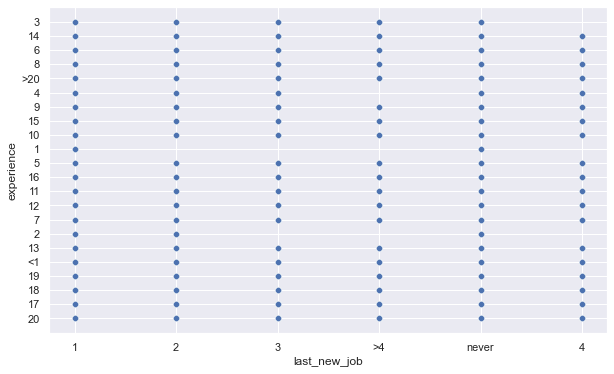

In [27]:
fig, ax = plt.subplots(figsize=(10,6))
sns.scatterplot(data=df, x='last_new_job', y='experience')

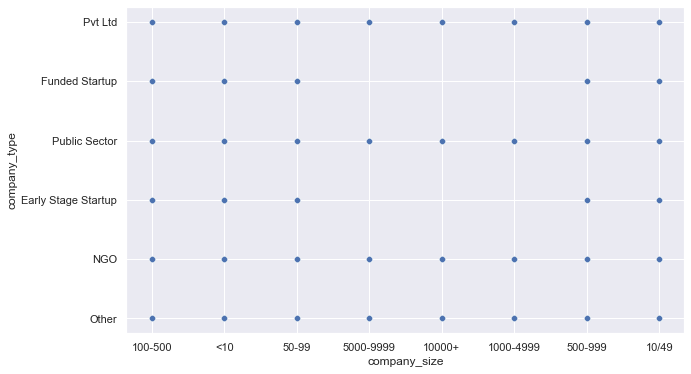

In [28]:
fig, ax = plt.subplots(figsize=(10,6))
sns.scatterplot(data=df, x='company_size', y='company_type')

In [29]:
df[df.company_type.isnull()].company_size.value_counts()

50-99        223
100-500      160
10/49        102
10000+        76
500-999       66
<10           65
1000-4999     63
5000-9999     34
Name: company_size, dtype: int64

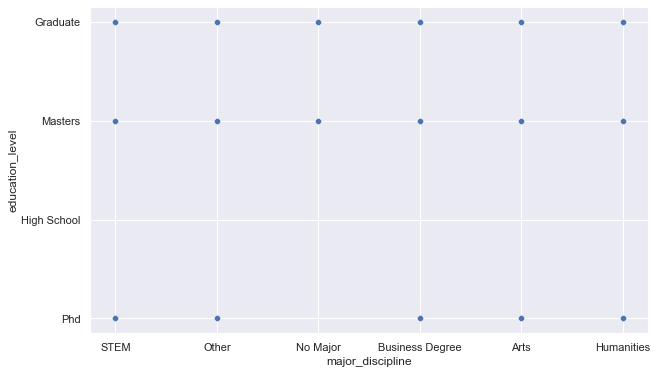

In [30]:
fig, ax = plt.subplots(figsize=(10,6))
sns.scatterplot(data=df, x='major_discipline', y='education_level')

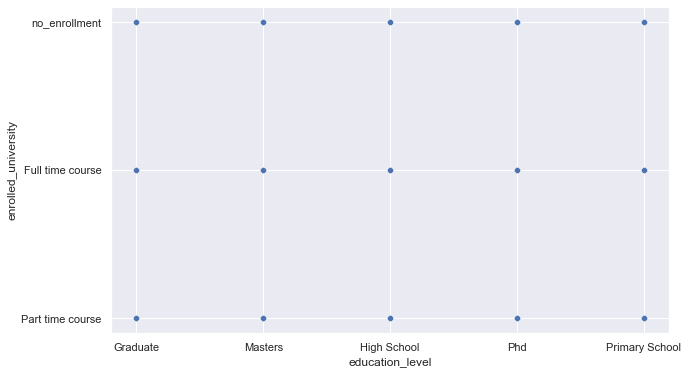

In [31]:
fig, ax = plt.subplots(figsize=(10,6))
sns.scatterplot(data=df, x='education_level', y='enrolled_university')

In [32]:
df[df.education_level=='Primary School'].major_discipline.isnull().sum() + df[df.education_level=='High School'].major_discipline.isnull().sum()

2355

In [36]:
# create a function to check the value_counts and value_counts ratio/pct for each variable 
def var_pct(data, column):
    count = data.value_counts(dropna=False)
    pct = round(count/(data.shape[0])*100,2)
    frame = pd.DataFrame(zip(count,pct), index=count.index, 
                         columns=['counts','pct']).reset_index().rename(columns={'index': column})
    
    return frame.sort_values('pct',ascending=False)

In [37]:
# check the value_counts pct for top 10 cities.
var_pct(df.city,'city').nlargest(10,'pct')

,city,counts,pct
0,city_103,4358,23.74
1,city_21,1672,9.11
2,city_16,1654,9.01
3,city_114,1472,8.02
4,city_160,827,4.50
5,city_136,624,3.40
6,city_67,455,2.48
7,city_75,332,1.81
8,city_104,318,1.73
9,city_102,313,1.70


In [38]:
df.city = df.city.map(lambda x: x.split('_')[1] if (df['city']==x).sum()/df.shape[0]*100 >= 1.7
                      else 'others').astype('str')

In [39]:
var_pct(df.major_discipline, 'major_discipline')

,major_discipline,counts,pct
0,STEM,13738,74.83
1,NaN,2838,15.46
2,Humanities,688,3.75
3,Other,343,1.87
4,Business Degree,307,1.67
5,Arts,239,1.30
6,No Major,206,1.12


In [40]:
# total is 2838
df[df.major_discipline.isnull()].education_level.value_counts(dropna=False)

High School       2032
NaN                457
Primary School     323
Graduate            19
Masters              7
Name: education_level, dtype: int64

In [41]:
var_pct(df.education_level, 'education_level')

,education_level,counts,pct
0,Graduate,10769,58.66
1,Masters,4319,23.53
2,High School,2032,11.07
3,Phd,459,2.50
4,NaN,457,2.49
5,Primary School,323,1.76


when education_level is NaN, major_discipline is also NaN so we will fill education_level NaN value with 0 
<br>and fill major_discipline 0 when education_level is 0

In [42]:
df.education_level.fillna(0, inplace=True)

In [43]:
df.loc[df.education_level == 0, 'major_discipline'] = 0

In [44]:
var_pct(df.major_discipline, 'major_discipline')
# where major_discipline is NaN there's 2355 datapoint's education_level is High school and Primary school
# so we should replace these NaN value with 0 as high school and primary school has no major.

,major_discipline,counts,pct
0,STEM,13738,74.83
1,NaN,2381,12.97
2,Humanities,688,3.75
3,0,457,2.49
4,Other,343,1.87
5,Business Degree,307,1.67
6,Arts,239,1.30
7,No Major,206,1.12


In [45]:
# replace these NaN in major_discipline with 0 as high school and primary school has no major.
for i in ['High School', 'Primary School']:
    df.loc[df.education_level == i, 'major_discipline']=0

In [46]:
# replace the rest NaN value in major_discipline with the most common value 'STEM'
df.major_discipline.fillna(df.major_discipline.mode()[0], inplace=True)

In [47]:
var_pct(df.major_discipline, 'major_discipline')

,major_discipline,counts,pct
0,STEM,13764,74.97
1,0,2812,15.32
2,Humanities,688,3.75
3,Other,343,1.87
4,Business Degree,307,1.67
5,Arts,239,1.30
6,No Major,206,1.12


In [48]:
df.major_discipline = df.major_discipline.map(lambda x: '2' if x == 'STEM' 
                                              else '1' if x in ['Humanities','Other','Business Degree', 'Arts']
                                              else 0 ).astype('float')

In [49]:
var_pct(df.education_level, 'level')

,level,counts,pct
0,Graduate,10769,58.66
1,Masters,4319,23.53
2,High School,2032,11.07
3,Phd,459,2.50
4,0,457,2.49
5,Primary School,323,1.76


In [50]:
df.education_level = df.education_level.map(lambda x: '1' if x in ['Primary School','High School']
                                           else '2' if x == 'Graduate'
                                           else '3' if x in ['Masters', 'Phd']
                                           else 0).astype('float')

In [51]:
var_pct(df.relevent_experience, 'relevent experience')

,relevent experience,counts,pct
0,Has relevent experience,13596,74.06
1,No relevent experience,4763,25.94


In [52]:
df.relevent_experience = df.relevent_experience.map(lambda x: '0' if x=='No relevent experience'
                                                   else '1').astype('float')

In [53]:
var_pct(df.experience, 'experience')

,experience,counts,pct
0,>20,3437,18.72
1,5,1309,7.13
2,4,1250,6.81
3,3,1159,6.31
4,6,1125,6.13
5,2,992,5.40
6,9,979,5.33
7,10,967,5.27
8,7,950,5.17
9,8,755,4.11


In [54]:
df.experience.fillna(df.experience.mode()[0], inplace=True)
df.experience = df.experience.map(lambda x: '0' if x == '<1'
                                  else '21' if x == '>20'
                                  else x).astype('float')

In [55]:
var_pct(df.last_new_job, 'last new job')

,last new job,counts,pct
0,1,7567,41.22
1,>4,3339,18.19
2,2,2835,15.44
3,never,2186,11.91
4,4,1038,5.65
5,3,1027,5.59
6,NaN,367,2.00


In [56]:
df.last_new_job = df.last_new_job.map(lambda x: '0' if x == 'never' 
                                      else '5' if x == '>4'
                                      else x if x is not None
                                      else None)

In [57]:
var_pct(df.company_type, 'company type')

,company type,counts,pct
0,Pvt Ltd,10051,54.75
1,NaN,5039,27.45
2,Funded Startup,1038,5.65
3,Public Sector,996,5.43
4,Early Stage Startup,582,3.17
5,NGO,534,2.91
6,Other,119,0.65


In [58]:
df.company_type = df.company_type.map(lambda x: '1' if x in ['Funded Startup', 'Early Stage Startup'] 
                                      else '2' if x in ['Public Sector', 'NGO', 'Other']
                                      else '3' if x == 'Pvt Ltd'
                                      else None)

In [59]:
var_pct(df.enrolled_university, 'univeristy enrollment')

,univeristy enrollment,counts,pct
0,no_enrollment,13659,74.40
1,Full time course,3187,17.36
2,Part time course,1171,6.38
3,NaN,342,1.86


In [60]:
df.enrolled_university = df.enrolled_university .map(lambda x: '0' if x=='no_enrollment'
                                                    else '1' if x in ['Full time course', 'Part time course']
                                                    else None)

In [61]:
var_pct(df.gender,'gender')

,gender,counts,pct
0,Male,12884,70.18
1,NaN,4098,22.32
2,Female,1188,6.47
3,Other,189,1.03


In [62]:
df.gender = df.gender.map(lambda x: '1' if x == 'Male' 
                         else '2' if x == 'Female'
                         else '3' if x == 'Other'
                         else None)

In [63]:
data_info(df)

,column,counts,unique_value_pct,nan_pct,data_type
0,enrollee_id,18359,100.00,0.00,int64
1,city,11,0.06,0.00,object
2,city_development_index,93,0.51,0.00,float64
3,gender,4,0.02,22.32,object
4,relevent_experience,2,0.01,0.00,float64
5,enrolled_university,3,0.02,1.86,object
6,education_level,4,0.02,0.00,float64
7,major_discipline,3,0.02,0.00,float64
8,experience,22,0.12,0.00,float64
9,company_size,9,0.05,26.03,object


In [64]:
impute_list = data_info(df)[data_info(df).nan_pct !=0].column.tolist()
impute_list 

['gender',
 'enrolled_university',
 'company_size',
 'company_type',
 'last_new_job']

In [65]:
#df[df.company_size.isnull()].company_type.value_counts(dropna=False)

In [66]:
#df.company_type.value_counts(dropna=False)

In [67]:
from sklearn.impute import KNNImputer

imputelist = ['gender',
 'enrolled_university',
 'company_type',
 'last_new_job']
imputer = KNNImputer(n_neighbors=1, weights="uniform")
df[imputelist] = imputer.fit_transform(df[imputelist])

In [68]:
df = round(df)

In [69]:
df[(df.last_new_job > df.experience)].experience.value_counts()

0.0    279
3.0     28
1.0     11
2.0      2
Name: experience, dtype: int64

In [70]:
for i in [0,1,2,3]:
    df.loc[df.experience == i, 'last_new_job']=0                            

In [71]:
df[(df.last_new_job > df.experience)]

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target


In [72]:
data_info(df)

,column,counts,unique_value_pct,nan_pct,data_type
0,enrollee_id,18359,100.00,0.00,int64
1,city,11,0.06,0.00,object
2,city_development_index,2,0.01,0.00,float64
3,gender,3,0.02,0.00,float64
4,relevent_experience,2,0.01,0.00,float64
5,enrolled_university,2,0.01,0.00,float64
6,education_level,4,0.02,0.00,float64
7,major_discipline,3,0.02,0.00,float64
8,experience,22,0.12,0.00,float64
9,company_size,9,0.05,26.03,object


In [73]:
df.loc[df.company_type == 1.0].company_size.value_counts()

50-99        509
<10          441
10/49        382
100-500      253
500-999       61
1000-4999      5
10000+         3
Name: company_size, dtype: int64

In [74]:
df.loc[df.company_type == 2.0].company_size.mode()[0]

'100-500'

In [75]:
df[df.company_size.isnull()].company_type.value_counts()

3.0    3607
1.0     684
2.0     488
Name: company_type, dtype: int64

In [76]:
3120+3607+684

7411

In [77]:
company_type = 1.0

mask = (df['company_type'] == company_type) & df['company_size'].isnull()

df.loc[mask, 'company_size'] = df.loc[df.company_type == company_type].company_size.mode()[0]

In [78]:
company_type = 3.0

mask = (df['company_type'] == company_type) & df['company_size'].isnull()

df.loc[mask, 'company_size'] = df.loc[df.company_type == company_type].company_size.mode()[0]

In [79]:
company_type = 2.0

mask = (df['company_type'] == company_type) & df['company_size'].isnull()

df.loc[mask, 'company_size'] = df.loc[df.company_type == company_type].company_size.mode()[0]

In [80]:
var_pct(df.company_size, 'size')

,size,counts,pct
0,50-99,7411,40.37
1,100-500,3186,17.35
2,10000+,2044,11.13
3,10/49,1466,7.99
4,1000-4999,1399,7.62
5,<10,1360,7.41
6,500-999,902,4.91
7,5000-9999,591,3.22


In [81]:
df[df.company_type==1.0].company_size.value_counts()

50-99        1193
<10           441
10/49         382
100-500       253
500-999        61
1000-4999       5
10000+          3
Name: company_size, dtype: int64

In [82]:
for i in ['1000-4999', '10000+']:
    df.loc[(df.company_type==1.0)&(df.company_size==i), 'company_size']='50-99'

In [83]:
var_pct(df.company_size, 'company_size')

,company_size,counts,pct
0,50-99,7419,40.41
1,100-500,3186,17.35
2,10000+,2041,11.12
3,10/49,1466,7.99
4,1000-4999,1394,7.59
5,<10,1360,7.41
6,500-999,902,4.91
7,5000-9999,591,3.22


In [84]:
df.company_size = df.company_size.map(lambda x: '1' if x in ['<10','10/49','50-99'] 
                                      else '2' if x in['100-500', '500-999'] 
                                      else '3' if x in ['1000-4999', '5000-9999', '10000+']
                                      else None).astype('float')

In [85]:
data_info(df)

,column,counts,unique_value_pct,nan_pct,data_type
0,enrollee_id,18359,100.00,0.0,int64
1,city,11,0.06,0.0,object
2,city_development_index,2,0.01,0.0,float64
3,gender,3,0.02,0.0,float64
4,relevent_experience,2,0.01,0.0,float64
5,enrolled_university,2,0.01,0.0,float64
6,education_level,4,0.02,0.0,float64
7,major_discipline,3,0.02,0.0,float64
8,experience,22,0.12,0.0,float64
9,company_size,3,0.02,0.0,float64


In [86]:
# We will not use enrolle_id as predictor, so drop this column from the dataset
df = df.drop('enrollee_id',axis=1)

In [87]:
# check the columns that are not float.
cat_col=data_info(df)[data_info(df).data_type=='object'].column.tolist()
int_col = data_info(df)[data_info(df).data_type=='int64'].column.tolist()
print("categorical list is:", cat_col)
print("int64 columns are: ", int_col)

categorical list is: ['city']
int64 columns are:  ['training_hours', 'target']


In [88]:
df[int_col] = df[int_col].astype('float')

In [89]:
data_info(df)

,column,counts,unique_value_pct,nan_pct,data_type
0,city,11,0.06,0.0,object
1,city_development_index,2,0.01,0.0,float64
2,gender,3,0.02,0.0,float64
3,relevent_experience,2,0.01,0.0,float64
4,enrolled_university,2,0.01,0.0,float64
5,education_level,4,0.02,0.0,float64
6,major_discipline,3,0.02,0.0,float64
7,experience,22,0.12,0.0,float64
8,company_size,3,0.02,0.0,float64
9,company_type,3,0.02,0.0,float64


In [249]:
# df.loc[df.experience==0, 'last_new_job'] = 'never'
# df.loc[df.experience==3, 'last_new_job'] = '1'

## 4.3 Count of unique values, NaN value percentage, data type

# creata a function to calculate unique value count and percentage for the whole dataset
# and check the data type for each column
def data_info(data):
    count = data.nunique(dropna=False)
    va_pct = round(count/(data.shape[0])*100,2)
    nan_p = round(data.isnull().sum()/data.shape[0]*100,2)
    frame = pd.DataFrame(zip(count,va_pct,nan_p), index=count.index, 
                         columns=['counts','unique_value_pct', 'nan_pct']).reset_index().rename(columns={'index': 'column'})
    
  
    frame['data_type']= df.dtypes.tolist()
    return frame

data_info(df).sort_values('counts', ascending=False)

## 4.4 Range of values per column

# This only contains numerical variables.
df.agg([min,max]).T

# This only contains numerical variables.
df.describe()

## 4.5 Detecting missing values

data_info(df)[data_info(df).nan_pct !=0].sort_values('nan_pct', ascending=False)

plt.figure(figsize=(8,6))
sns.heatmap(df.isnull(), cbar=True)
plt.show()

## 4.6 Data inspection and data grouping (without filling NaN value)

<br>1. Check the details of values within each colum/variable:
Break dowon of the unique values and their percentage, and detecting incorrect input.
<br>2. Group some of the categorical varaibles if necessary.
<br>3. Convert categorical values to numbers.

# create a function to check the value_counts and value_counts ratio/pct for each variable 
def var_pct(data, column):
    count = data.value_counts(dropna=False)
    pct = round(count/(data.shape[0])*100,2)
    frame = pd.DataFrame(zip(count,pct), index=count.index, 
                         columns=['counts','pct']).reset_index().rename(columns={'index': column})
    
    return frame.sort_values('pct',ascending=False)

# Call function var_pct() on column 'target', enrollee who is open to a new employment is labeled as 1
# label 1 is also considered as 'target' in this dataset, label 0 is considered as 'non-target'
print(var_pct(df['target'], 'label').to_markdown())

# Let's check the percentage in a pie graph, we can see the ratio of value 1 and 0 is about 1:6. 
df_target = var_pct(df['target'], 'label')
plt.pie(df_target.counts, labels= df_target.label, autopct='%.2f%%')
plt.show()


We can see the data is imbalanced. The ratio of the positive class (1) and negative class (0) is about 1:6

# check the value_counts pct for top 10 cities.
var_pct(df.city,'city').nlargest(10,'pct')

# if the city's value_count ratio is lower than 1.7 then group them to 'Others'
df.city = df.city.map(lambda x: x.split('_')[1] if (df['city']==x).sum()/df.shape[0]*100 >= 1.7
                      else 'others').astype('str')

var_pct(df.company_size, 'company_size')

# we can see value '10/49' should be '10-49', value '100-500' should be '100-499'
df.company_size = df.company_size.map(lambda x: '1' if x in ['<10','10/49','50-99'] 
                                      else '2' if x in['100-500', '500-999'] 
                                      else '3' if x in ['1000-4999', '5000-9999', '10000+']
                                      else None)

var_pct(df.company_type, 'company type')

df.company_type = df.company_type.map(lambda x: '1' if x in ['Funded Startup', 'Early Stage Startup'] 
                                      else '2' if x in ['Public Sector', 'NGO', 'Other']
                                      else '3' if x == 'Pvt Ltd'
                                      else None)

var_pct(df.experience, 'experience')

df.experience = df.experience.map(lambda x: '0' if x == '<1'
                                  else '21' if x == '>20'
                                  else x if x is not None
                                  else None)

var_pct(df.last_new_job, 'last new job')

df.last_new_job = df.last_new_job.map(lambda x: '0' if x == 'never' 
                                      else '5' if x == '>4'
                                      else x if x is not None
                                      else None)

var_pct(df.relevent_experience, 'relevent experience')

df.relevent_experience = df.relevent_experience.map(lambda x: '0' if x=='No relevent experience'
                                                   else '1')

var_pct(df.major_discipline, 'major')

df.major_discipline = df.major_discipline.map(lambda x: '1' if x == 'STEM' 
                                              else '0' if x in ['Humanities','Other','Business Degree', 'Arts', 'No Major']
                                              else None )

var_pct(df.enrolled_university, 'univeristy enrollment')

df.enrolled_university = df.enrolled_university .map(lambda x: '0' if x=='no_enrollment'
                                                    else '1' if x in ['Full time course', 'Part time course']
                                                    else None)

var_pct(df.education_level, 'education level')

df.education_level = df.education_level.map(lambda x: '1' if x in ['Primary School','High School']
                                           else '2' if x == 'Graduate'
                                           else '3' if x in ['Masters', 'Phd']
                                           else None)

var_pct(df.gender, 'gender')

df.gender = df.gender.map(lambda x: '1' if x == 'Male' 
                         else '2' if x == 'Female'
                         else '3' if x == 'Other'
                         else None)

data_info(df)[data_info(df).nan_pct !=0].sort_values('nan_pct', ascending=False)

impute_list = data_info(df)[data_info(df).nan_pct !=0].column.tolist()
impute_list 

## 4.7 Missing value imputation

Fill missing value with KNN imputer

from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=1, weights="uniform")
df[impute_list] = imputer.fit_transform(df[impute_list]) 

# make sure there's no more missing values
data_info(df).sort_values('counts', ascending=False)

# We will not use enrolle_id as predictor, so drop this column from the dataset
df = df.drop('enrollee_id',axis=1)

# check the columns that are not float.
cat_col=data_info(df)[data_info(df).data_type=='object'].column.tolist()
int_col = data_info(df)[data_info(df).data_type=='int64'].column.tolist()
print("categorical list is:", cat_col)
print("int64 columns are: ", int_col)

# convert relevent_experience from object to float, and use dummy encoder to encode 'city' later.
df.relevent_experience = df.relevent_experience.astype('float')

# convert all the int64 to float data type. 
df[int_col] = df[int_col].astype('float')

data_info(df).sort_values('counts',ascending=False)

# 5 Exploratory data analysis (EDA)

## 5.1 Summary statistics

df.describe().T

# create a function to build a table 
def var_target_df(data,col):
    dataframe = pd.crosstab(data[col],df['target'])
    dataframe['target pct'] = dataframe[1]/dataframe.sum(axis=1)*100
    dataframe = round(dataframe,2)
    dataframe.columns.name=None
    dataframe = dataframe.rename(columns={0:'non-target', 1:'target'})
    dataframe.index.name = None
    dataframe['sum'] = dataframe.sum(axis=1)
    dataframe = dataframe.sort_values('sum',ascending=False)
    dataframe = dataframe.drop('sum',axis=1)
    return dataframe
    

def barplot(data, col, labels):
    fig, ax = plt.subplots(figsize=(10,6))
    sns.countplot(x=col, hue="target", data=df, order = data[col].value_counts().index, ax=ax)
    ax.set_title('target vs %s'%col, fontsize=16, fontweight='bold')
    ax.set_xticklabels(labels)
    ax.set_xlabel(col,fontsize=14)
    ax.set_ylabel('count', fontsize=14)
    ax.legend(['non-target', 'target'])
    plt.show()


# create function to make histogram with min, max, 1st, 2nd(median), 3rd quantile.
def create_hist_withquantile(data,col,n):
    per50 = df[col].describe()['50%']
    per25 = df[col].describe()['25%']
    per75 = df[col].describe()['75%']
    min = df[col].describe()['min']
    max = df[col].describe()['max']
    cityidx = sns.displot(df,x=col,hue='target', multiple='stack', bins=n)
    cityidx.fig.set_figwidth(11)
    cityidx.fig.set_figheight(6)
    plt.axvline(per50,color='r')
    plt.axvline(per25,color='r',linestyle='--')
    plt.axvline(per75,color='r',linestyle='--')
    plt.axvline(min,color='r',linestyle='-.')
    plt.axvline(max,color='r',linestyle='-.')
    plt.xlabel(col)
    plt.ylabel('count')
    plt.show()

## Target vs. City

# plot table and barplot for city
print(var_target_df(df,'city').to_markdown())
barplot(df, 'city', df.city.value_counts().index)

# Top 3 city that has the highest ratio of target(class 1.0)
var_target_df(df,'city').nlargest(columns='target pct', n=3)

# plot table and histogram for city_development_index top 10
print(var_target_df(df,'city_development_index').nlargest(columns='target', n=10).to_markdown())
create_hist_withquantile(df, 'city_development_index', 20)

df[df.city_development_index == 0.920].city.value_counts()

indexlist = var_target_df(df,'city_development_index').nlargest(columns='target', n=10).index
for i in indexlist:
        print (df[df.city_development_index == i].city.value_counts().index)

## Target vs. Experience

# table and bar plot for relevent_experience
print(var_target_df(df , 'relevent_experience').rename(index = {1: 'Has relevent experience' , 0: 'No relevent experience'}).to_markdown())
barplot(df, 'relevent_experience', ['Has relevent experience', 'No relevent experience'])

print(var_target_df(df, 'last_new_job').rename(index = {0:'never' , 5:'4+'}).to_markdown())
barplot(df, 'last_new_job', ['1', '4+', '2', 'never', '4', '3'])

# Plot boxplot for experience vs target
print(df.groupby('target')['experience'].describe().rename(index = {0:'non-target' , 1:'target'}).to_markdown())

fig, ax = plt.subplots(figsize=(8,6))
ax = sns.boxplot(x='target', y='experience', data=df)
ax.set_title('target vs experience' , fontsize=16, fontweight='bold')
ax.set_xticklabels(['non-target', 'target'],rotation=0)
ax.set_xlabel('target',fontsize=14)
ax.set_ylabel('experience', fontsize=14)
plt.show()

## Target vs. Education

print(var_target_df(df, 'major_discipline').rename(index = {0:'Others' , 1:'STEM'}).to_markdown())
barplot(df, 'major_discipline', ['STEM', 'Others'])

# table and bar plot for education_level
print(var_target_df(df, 'education_level').rename(index = {1:'Highschool or lower' , 2: 'Graduate', 3: 'Master or higher'}).to_markdown())
barplot(df, 'education_level', ['Graduate', 'Master or higher', 'Highschool or lower'])

# table and bar plot for univeristy enrollment
print(var_target_df(df, 'enrolled_university').rename(index = {1: 'Full or part time' , 0: 'No enrollment'}).to_markdown())
barplot(df, 'enrolled_university', ['No enrollment', 'Full or part time'])

## Target vs. Company

# table and bar plot for company_type
print(var_target_df(df, 'company_type').rename(index = {1:'Start up' , 2: 'Others', 3: 'Pvt Ltd'}).to_markdown())
barplot(df, 'company_type', ['Pvt Ltd', 'Others', 'Start up'])

print(var_target_df(df, 'company_size').rename(index = {1:'0-99' , 2: '100-999', 3: '1000+'}).to_markdown())
barplot(df, 'company_size', ['0-99', '1000+', '100-999'])

## Target vs. Gender

print(var_target_df(df, 'gender').rename(index = {1:'Male' , 2:'Female', 3:'Others'}).to_markdown())
barplot(df, 'gender', ['Male', 'Female', 'Others'])

## Target vs. Training Hours

print(df.groupby('target')['training_hours'].describe().rename(index = {0:'non-target' , 1:'target'}).to_markdown())
create_hist_withquantile(df,'training_hours',100)

#sns.pairplot(df, hue='target')

df.head()

weird = df.loc[(df.last_new_job > df.experience)].index.tolist()

# Pre-processing and training data preparation

In [90]:
# encode the last object column 'city' via dummy encoding
cat_col= data_info(df)[data_info(df).data_type=='object'].column.tolist()
df = pd.get_dummies(df,columns=cat_col)
df.head()

,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,...,city_103,city_104,city_114,city_136,city_16,city_160,city_21,city_67,city_75,city_others
0,1.0,1.0,1.0,0.0,2.0,2.0,3.0,2.0,3.0,0.0,...,0,0,0,0,0,0,0,0,0,1
1,1.0,1.0,1.0,0.0,2.0,2.0,14.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,1
2,1.0,1.0,1.0,0.0,2.0,2.0,6.0,1.0,2.0,2.0,...,0,0,0,0,1,0,0,0,0,0
3,1.0,1.0,1.0,0.0,2.0,2.0,14.0,1.0,3.0,1.0,...,0,0,0,0,0,0,0,0,0,1
4,1.0,2.0,0.0,0.0,3.0,2.0,8.0,2.0,2.0,2.0,...,0,0,0,0,0,0,0,0,0,1


In [91]:
df.shape

(18359, 23)

In [92]:
data_info(df)

,column,counts,unique_value_pct,nan_pct,data_type
0,city_development_index,2,0.01,0.0,float64
1,gender,3,0.02,0.0,float64
2,relevent_experience,2,0.01,0.0,float64
3,enrolled_university,2,0.01,0.0,float64
4,education_level,4,0.02,0.0,float64
5,major_discipline,3,0.02,0.0,float64
6,experience,22,0.12,0.0,float64
7,company_size,3,0.02,0.0,float64
8,company_type,3,0.02,0.0,float64
9,last_new_job,6,0.03,0.0,float64


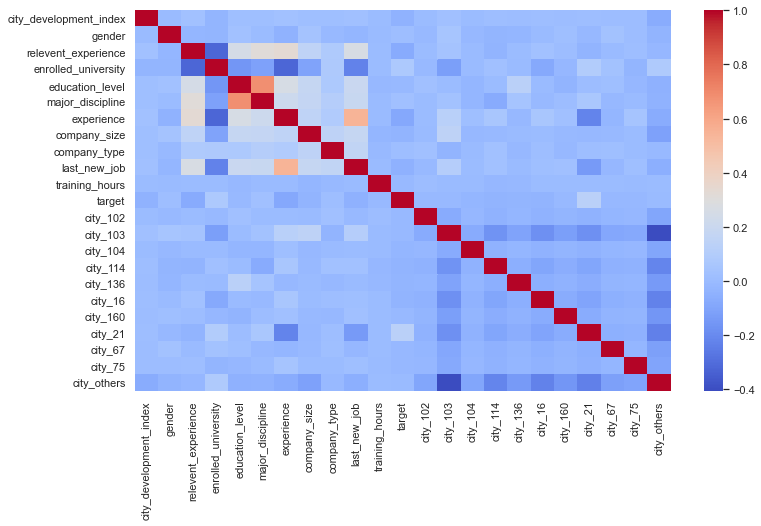

In [93]:
# check correlation between each variable
_= plt.subplots(figsize=(12,7))
sns.heatmap(df.corr(),cmap='coolwarm') 
plt.show()

In [94]:
X = df.drop('target',axis=1)
y = df['target'].ravel()

In [95]:
X.head()

,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,...,city_103,city_104,city_114,city_136,city_16,city_160,city_21,city_67,city_75,city_others
0,1.0,1.0,1.0,0.0,2.0,2.0,3.0,2.0,3.0,0.0,...,0,0,0,0,0,0,0,0,0,1
1,1.0,1.0,1.0,0.0,2.0,2.0,14.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,1
2,1.0,1.0,1.0,0.0,2.0,2.0,6.0,1.0,2.0,2.0,...,0,0,0,0,1,0,0,0,0,0
3,1.0,1.0,1.0,0.0,2.0,2.0,14.0,1.0,3.0,1.0,...,0,0,0,0,0,0,0,0,0,1
4,1.0,2.0,0.0,0.0,3.0,2.0,8.0,2.0,2.0,2.0,...,0,0,0,0,0,0,0,0,0,1


In [96]:
# X_scaled = StandardScaler().fit_transform(X)

# X_train,X_test,y_train,y_test = train_test_split(X_scaled, y, test_size=0.30, stratify=y, random_state=43)


from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() 
X_scaled = scaler.fit_transform(X)
X_train,X_test,y_train,y_test = train_test_split(X_scaled, y, test_size=0.30, stratify=y, random_state=43)

In [97]:
# check target count in full, train, test dataset 
target_test_set = np.unique(y_test,return_counts=True)[1]
target_train_set = np.unique(y_train,return_counts=True)[1]
target_full_set= np.unique(df.target,return_counts=True)[1]

In [98]:
df_target = pd.DataFrame([target_full_set,target_train_set,target_test_set ], 
                         index=['Full Dataset', 'Training set', 'Testing set'], 
                         columns=['non-target count', 'target count'])

df_target['target %'] = round(df_target['target count']/df_target.sum(axis=1)*100,3)
df_target

,non-target count,target count,target %
Full Dataset,15934,2425,13.209
Training set,11154,1697,13.205
Testing set,4780,728,13.217


In [99]:
# Check how imbalanced the data is in y_train.
np.unique(y_train, return_counts=True)[1][0]/np.unique(y_train, return_counts=True)[1][1]

6.572775486152033

In [100]:
# we can see in our y_train, the ratio between negative and positive classes are 6.6 : 1 
# This class imbalance may cause some negative effect when we train the model.
# As our models look at the data and cleverly decide that the best thing to do is to always predict negative class and achieve high accuracy.
# If that happens we will normally get high accuracy but low recall or sometimes even zero recall, precision as the model will only predict negative class.

In [101]:
index = ['LR','GNB','KNN','SVC','DT','RF','GB','XGB','LightGB']

models = [LogisticRegression(),
          GaussianNB(),
          KNeighborsClassifier(),
          SVC(probability=True, random_state=43),
          DecisionTreeClassifier(random_state=43),
          RandomForestClassifier(random_state=43),
          GradientBoostingClassifier(random_state=43),
          XGBClassifier(random_state=43),
          lgb.LGBMClassifier(objective='binary',random_state=43)]

    # combine index and models to a dictionary
model_dict = dict(zip(index,models))

In [102]:
# create a function to train model with n fold cv and return the result
def model_eval(model_name, X, y, n):
    scoring = {
           'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score),
           'roc_auc' : make_scorer(roc_auc_score, needs_proba=True)}

    kfold = KFold(n_splits=n)
    model = model_name

    model_res = model_selection.cross_validate(
                                          estimator=model,
                                          X=X,
                                          y=y,
                                          cv=kfold,
                                          scoring=scoring)
    
    res = pd.DataFrame(model_res).round(3)
    return res

In [103]:
# create a function to return the test result for all models
def allmodel_perform(X, y, n, model_eval):
    # create a empty list to put the average model test_score from the validation
    model_score_average = []
    
    # Loop inside the model_dict and average the test_score by calling function model_eval()
    # (test_score contains: accuracy, precision, recall, fscore, roc_auc_score)
    # Append the avarage score to list 'model_score_average' 
    for model in model_dict.values():
        model_score_average.append(model_eval(model,X,y,n).mean())


    # put the model_score_average into a dataframe 
    df_model_eval = pd.DataFrame(model_score_average,index=list(model_dict.keys())).round(3)
    df_model_eval = df_model_eval.reset_index().rename(columns={'index':'model'})
    return df_model_eval

In [104]:
model_res = allmodel_perform(X_train, y_train, 5, model_eval)
model_res

,model,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1_score,test_roc_auc
0,LR,0.052,0.009,0.868,0.000,0.000,0.000,0.634
1,GNB,0.004,0.008,0.800,0.261,0.278,0.268,0.629
2,KNN,0.126,0.796,0.851,0.222,0.051,0.083,0.562
3,SVC,15.276,0.508,0.868,0.000,0.000,0.000,0.547
4,DT,0.030,0.007,0.766,0.156,0.175,0.165,0.516
5,RF,0.715,0.105,0.853,0.257,0.057,0.093,0.589
6,GB,0.758,0.013,0.868,0.480,0.005,0.009,0.633
7,XGB,0.365,0.014,0.860,0.249,0.033,0.058,0.603
8,LightGB,0.089,0.013,0.867,0.233,0.008,0.016,0.621


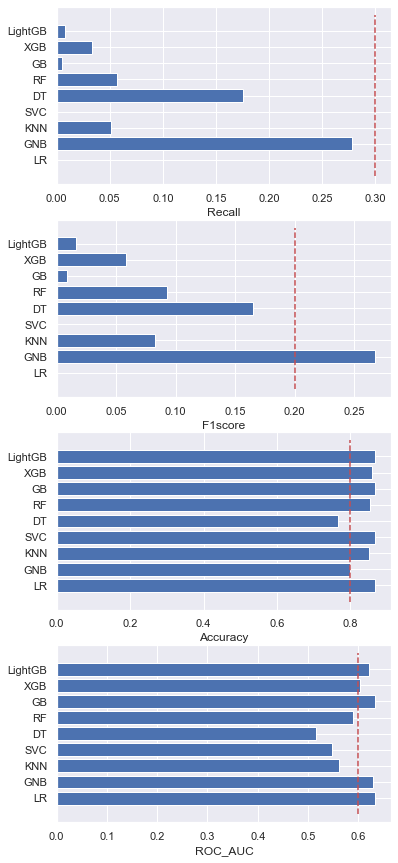

In [105]:
# plot barh plot to check the average score of recall, fscore, accuracy, roc_auc from cross validation
fig,axs = plt.subplots(4,1, figsize=(6,15))

axs[0].barh('model', 'test_recall', data=model_res)
axs[1].barh('model', 'test_f1_score', data=model_res)
axs[2].barh('model', 'test_accuracy', data=model_res)
axs[3].barh('model', 'test_roc_auc',data=model_res)

axs[0].set_xlabel('Recall')
axs[1].set_xlabel('F1score')
axs[2].set_xlabel('Accuracy')
axs[3].set_xlabel('ROC_AUC')


axs[0].plot([0.3,0.3],[-1,9],'r--')
axs[1].plot([0.2,0.2],[-1,9],'r--')
axs[2].plot([0.8,0.8],[-1,9],'r--')
axs[3].plot([0.6,0.6],[-1,9],'r--')
plt.show()

In [106]:
def trainmodel_cv(model_name, X, y, n):
    
    kfold = KFold(n_splits=n)
    model = model_name

    model_res = model_selection.cross_validate(
                                          estimator=model,
                                          X=X,
                                          y=y,
                                          cv=kfold)
    model.fit(X_train, y_train)
    return model

In [107]:
# train model with n cross validation 
# then plot lift curve and 'predicted probability' vs 'label of test data' histogram based on model prediction 
# then return model score on test data 
import scikitplot as skplt 

def liftcurve_probahisto_score(trainmethod, model, model_name, n, Xtest, ytest, ylim1, ylim2):
    
    # replace trainmethod with trainmodel_cv or trainmodel_os_cv
    final_model = trainmethod(model, X_train, y_train, n)
    
    # get prediction from test dataset
    yfinal = final_model.predict(Xtest)
    yfinal_proba = final_model.predict_proba(Xtest)[:,1]
    y_probas = final_model.predict_proba(Xtest)
    
    figure, (ax1,ax2) = plt.subplots(1,2, figsize=(16,4))
    skplt.metrics.plot_lift_curve(y_true=ytest, y_probas=y_probas, ax=ax1)
    ax1.set_ylim([0, ylim1])
    ax1.set_xlabel('Percentage of sample', fontsize=12)
    ax1.set_ylabel('Lift', fontsize=12)

    
    predProba_label = pd.DataFrame()
    #predProba_label['proba'] =(yfinal_proba - yfinal_proba.min())/(yfinal_proba.max() - yfinal_proba.min())
    predProba_label['proba'] = yfinal_proba
    predProba_label['label'] = ytest
    percent20 = round(len(ytest)*0.2)
    percent50 = round(len(ytest)*0.5)
    positive_in_top20pct = round(predProba_label,4).sort_values('proba', ascending=False).nlargest(percent20,'proba').label.sum()
    positive_in_top50pct = round(predProba_label,4).sort_values('proba', ascending=False).nlargest(percent50,'proba').label.sum()
    
    
    weights_1 = np.ones_like(predProba_label[predProba_label['label']==1].proba.index)/len(predProba_label[predProba_label['label']==1].proba.index)
    predProba_label[predProba_label['label']==1].proba.plot(kind='hist',
                                                                      bins=10,
                                                                      color='r',
                                                                      label='positive',
                                                                      histtype='step',
                                                                      stacked=False,
                                                                      lw=2,
                                                                      weights=weights_1,
                                                                      ax=ax2)


    weights_2 = np.ones_like(predProba_label[predProba_label['label']==0].proba.index)/len(predProba_label[predProba_label['label']==0].proba.index)
    predProba_label[predProba_label['label']==0].proba.plot(kind='hist',
                                                                     bins=10,
                                                                     label='negative',
                                                                     histtype='step',
                                                                     stacked=False,
                                                                     lw=2,
                                                                     weights=weights_2,
                                                                     ax=ax2)
    

    ax2.set_xlabel('Probability of prediction', fontsize=12)
    ax2.set_ylabel('Fraction of observation', fontsize=12)
    ax2.set_ylim([0, ylim2])
    ax2.legend()
    ax2.set_title('Predicted probability vs class',fontsize=12)
    
    #plt.suptitle(model,fontsize=12,fontweight='bold')
    precision, recall, f1score, support = score(ytest, yfinal, pos_label=1,average='binary')
    roc_auc = roc_auc_score(ytest, yfinal_proba)
    dataframe = pd.DataFrame([precision, recall, f1score, roc_auc, positive_in_top20pct, positive_in_top50pct],
                       index=['precison','recall','f1score','roc_auc', 'positive_in_top20pct', 'positive_in_top50pct'], 
                       columns=[model_name]).T
    
    return round(dataframe, 3)

,precison,recall,f1score,roc_auc,positive_in_top20pct,positive_in_top50pct
LogisticRegression,0.0,0.0,0.0,0.64,616.0,1134.0


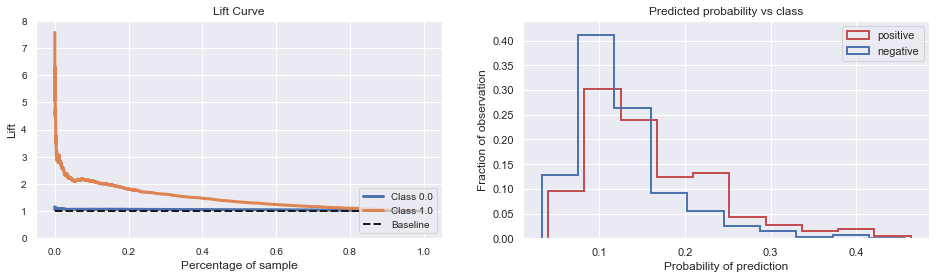

In [124]:
liftcurve_probahisto_score(trainmodel_cv,LogisticRegression(), 'LogisticRegression', 5, X_train, y_train, 8, 0.44)

,precison,recall,f1score,roc_auc,positive_in_top20pct,positive_in_top50pct
LogisticRegression,0.0,0.0,0.0,0.622,260.0,469.0


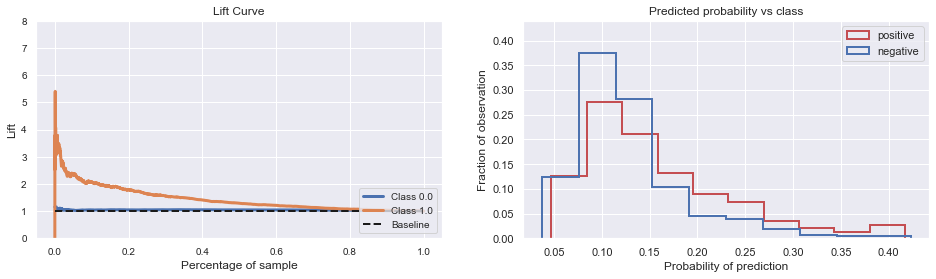

In [123]:
liftcurve_probahisto_score(trainmodel_cv,LogisticRegression(), 'LogisticRegression', 5, X_test, y_test, 8, 0.44)

,precison,recall,f1score,roc_auc,positive_in_top20pct,positive_in_top50pct
GaussianNB,0.263,0.272,0.267,0.633,595.0,1119.0


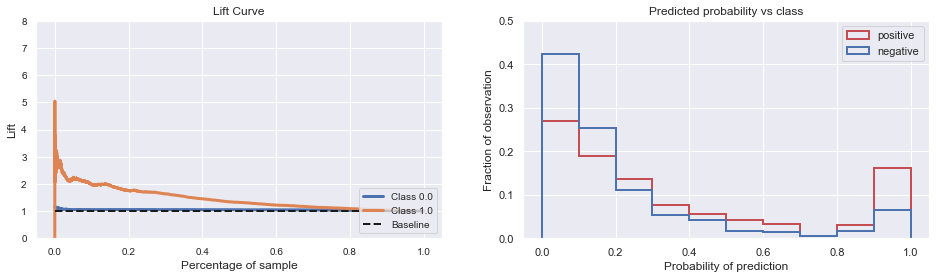

In [121]:
liftcurve_probahisto_score(trainmodel_cv, GaussianNB(), 'GaussianNB', 5, X_train, y_train, 8, 0.5)

,precison,recall,f1score,roc_auc,positive_in_top20pct,positive_in_top50pct
GaussianNB,0.261,0.261,0.261,0.605,253.0,447.0


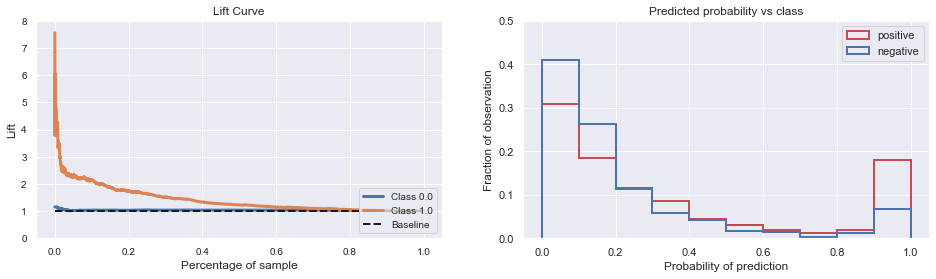

In [122]:
liftcurve_probahisto_score(trainmodel_cv, GaussianNB(), 'GaussianNB', 5, X_test, y_test, 8, 0.5)

In [112]:
# create function to train models with n fold cross validation and oversample data only on the train fold in each cross validation 
# and return test result of score precision, recall, f1score, auc, roc_auc
def model_eval_os(model_name, X, y, n):
    
    precisions = []
    recalls = []
    f1scores = []
    aucs = []
    roc_aucs=[]
    
    cv = KFold(n_splits=n)
    for i, (train, test) in enumerate(cv.split(X, y)):
        X_train_fold, y_train_fold = X[train], y[train]
        X_test_fold, y_test_fold = X[test], y[test]
        
        os = SMOTE(random_state=43)
        X_train_oversampled, y_train_oversampled = os.fit_sample(X_train_fold, y_train_fold)
        model = model_name
        
        model.fit(X_train_oversampled, y_train_oversampled)
        
        y_pred = model.predict(X_test_fold)
        y_pred_proba = model.predict_proba(X_test_fold)[:,1]
        
       
        recalls.append(recall_score(y_test_fold, y_pred, pos_label=1,average='binary'))
        precisions.append(precision_score(y_test_fold, y_pred, pos_label=1,average='binary'))
        f1scores.append(f1_score(y_test_fold, y_pred, pos_label=1,average='binary'))
        roc_aucs.append(roc_auc_score(y_test_fold, y_pred_proba))
        aucs.append(model.score(X_test_fold, y_test_fold))
     
    
    res = pd.DataFrame([precisions,recalls,f1scores,aucs,roc_aucs]).T
    res.columns = ['test_precison', 'test_recall', 'test_f1score', 'test_accuracy', 'test_roc_auc']
    
    return res

In [113]:
# call function allmodel_perform() to get the test for all models 
# using model_eval_os() function to get result after oversampling dataset

model_res_os = allmodel_perform(X_train, y_train, 5, model_eval_os)

In [114]:
model_res_os.sort_values('test_recall', ascending=False)

,model,test_precison,test_recall,test_f1score,test_accuracy,test_roc_auc
1,GNB,0.167,0.676,0.267,0.510,0.622
3,SVC,0.194,0.542,0.286,0.642,0.626
0,LR,0.193,0.537,0.284,0.643,0.629
2,KNN,0.166,0.408,0.236,0.650,0.565
4,DT,0.163,0.225,0.188,0.744,0.524
6,GB,0.249,0.149,0.186,0.828,0.604
5,RF,0.190,0.134,0.157,0.810,0.589
7,XGB,0.251,0.062,0.099,0.852,0.601
8,LightGB,0.276,0.062,0.101,0.855,0.616


In [115]:
# create a function to train final model on oversampled data with n fold cross validation and return final model.
def trainmodel_os_cv(model, X, y, n):
    
    cv = KFold(n_splits=n)
    for i, (train, test) in enumerate(cv.split(X,y)):
        X_train_fold, y_train_fold = X[train], y[train]
        X_test_fold, y_test_fold = X[test], y[test]
        
        os = SMOTE(random_state=43)
        X_train_oversampled, y_train_oversampled = os.fit_sample(X_train_fold, y_train_fold)
        model.fit(X_train_oversampled, y_train_oversampled)
    
    return model

In [116]:
# # train model on oversampled data with n cross validation 
# # then plot lift curve and 'predicted probability' vs 'label of test data' histogram based on model prediction 
# # then return model score on test data 
# import scikitplot as skplt 

# def liftcurve_probahisto_score(model, model_name, n, Xtest, ytest, ylim1, ylim2):
    
#     # use function trainmodel_os_cv() to train model on oversampled X_train, y_train with n cv 
#     final_model = trainmodel_os_cv(model, X_train, y_train, n)
    
#     # get prediction from test dataset
#     yfinal = final_model.predict(Xtest)
#     yfinal_proba = final_model.predict_proba(Xtest)[:,1]
#     y_probas = final_model.predict_proba(Xtest)
    
#     figure, (ax1,ax2) = plt.subplots(1,2, figsize=(16,4))
#     skplt.metrics.plot_lift_curve(y_true=ytest, y_probas=y_probas, ax=ax1)
#     ax1.set_ylim([0, ylim1])
#     ax1.set_xlabel('Percentage of sample', fontsize=12)
#     ax1.set_ylabel('Lift', fontsize=12)

    
#     predProba_label = pd.DataFrame()
#     predProba_label['proba'] =(yfinal_proba - yfinal_proba.min())/(yfinal_proba.max() - yfinal_proba.min())
#     #predProba_label['proba'] = yfinal_proba
#     predProba_label['label'] = ytest
#     percent20 = round(len(ytest)*0.2)
#     percent50 = round(len(ytest)*0.5)
#     positive_in_top20pct = round(predProba_label,4).sort_values('proba', ascending=False).nlargest(percent20,'proba').label.sum()
#     positive_in_top50pct = round(predProba_label,4).sort_values('proba', ascending=False).nlargest(percent50,'proba').label.sum()
    
    
#     weights_1 = np.ones_like(predProba_label[predProba_label['label']==1].proba.index)/len(predProba_label[predProba_label['label']==1].proba.index)
#     predProba_label[predProba_label['label']==1].proba.plot(kind='hist',
#                                                                       bins=10,
#                                                                       color='r',
#                                                                       label='positive',
#                                                                       histtype='step',
#                                                                       stacked=False,
#                                                                       lw=2,
#                                                                       weights=weights_1,
#                                                                       ax=ax2)


#     weights_2 = np.ones_like(predProba_label[predProba_label['label']==0].proba.index)/len(predProba_label[predProba_label['label']==0].proba.index)
#     predProba_label[predProba_label['label']==0].proba.plot(kind='hist',
#                                                                      bins=10,
#                                                                      label='negative',
#                                                                      histtype='step',
#                                                                      stacked=False,
#                                                                      lw=2,
#                                                                      weights=weights_2,
#                                                                      ax=ax2)
    
# #    sns.histplot(predProba_label, x='proba', hue='label', stat='probability', element='step',bins=10, ax=ax2)
# #     ax2.hist(predProba_label[predProba_label.label==1].proba, density=True, histtype='step',label='Positive',color='r' , lw=2)
# #     ax2.hist(predProba_label[predProba_label.label==0].proba, density=True, histtype='step',label='Negative', lw=2)
# #     ax2.set_ylim([0,10.0])
#     ax2.set_xlabel('Probability of prediction', fontsize=12)
#     ax2.set_ylabel('Fraction of observation', fontsize=12)
#     ax2.set_ylim([0, ylim2])
#     ax2.legend()
#     ax2.set_title('Predicted probability vs class',fontsize=12)
    
#     #plt.suptitle(model,fontsize=12,fontweight='bold')
#     precision, recall, f1score, support = score(ytest, yfinal, pos_label=1,average='binary')
#     roc_auc = roc_auc_score(ytest, yfinal_proba)
#     dataframe = pd.DataFrame([precision, recall, f1score, roc_auc, positive_in_top20pct, positive_in_top50pct],
#                        index=['precison','recall','f1score','roc_auc', 'positive_in_top20pct', 'positive_in_top50pct'], 
#                        columns=[model_name]).T
    
#     return round(dataframe, 3)

There's 728 positive datapoints(label=1) in y_test which contains 5508 datapoints.
<br>If we use LogisticRegression we can capture 264, 469 <b>label1</b> among the top 20%, top50% of the predicted result,
<br>meaning we can capture 36.3%, 64.4% of <b>label1</b> from the top20%,  top50% predicted result. (264/728=0.363)
<br>While using GaussianNB we can only capture 250, 449 label1 among the top 20%, top50% of the predicted result.
<br>meaning we can capture 34.3%,  61.7% of <b>label1</b> from the top20%, top50% predicted result.
<br>* Question 1: Therefore we should choose LogisticRegression as the final model?
<br>* Question 2: As my dataset contains both continuous variables and discrete variables, so I am no very sure if I can use GaussianNB classifier in this case


,precison,recall,f1score,roc_auc,positive_in_top20pct,positive_in_top50pct
LogisticRegression,0.194,0.537,0.285,0.632,608.0,1120.0


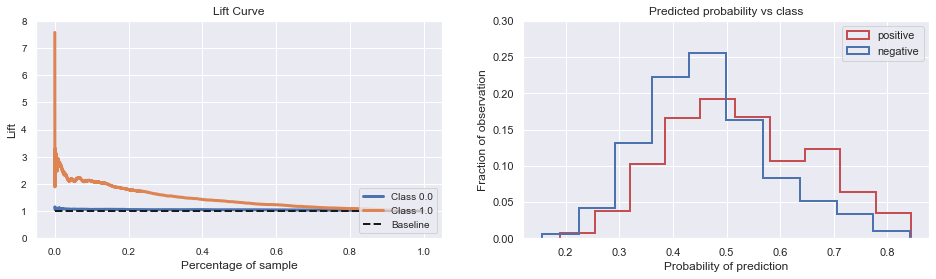

In [117]:
# get liftcurve, probahisto and scores on X_train, y_train for model LR

liftcurve_probahisto_score(trainmodel_os_cv, LogisticRegression(), 'LogisticRegression', 5, X_train, y_train, 8, 0.3)

,precison,recall,f1score,roc_auc,positive_in_top20pct,positive_in_top50pct
LogisticRegression,0.189,0.518,0.277,0.616,254.0,467.0


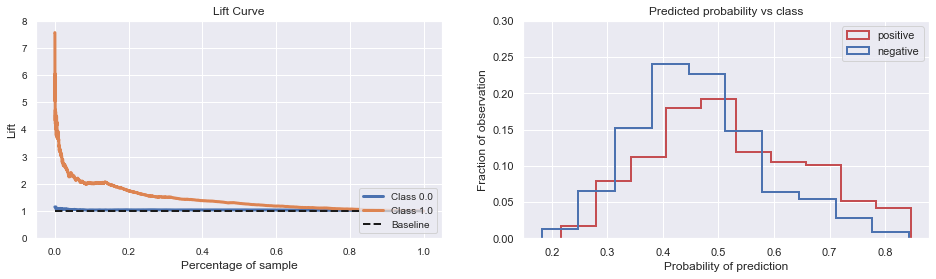

In [118]:
# get liftcurve, probahisto and scores on X_test, y_test for model LR
liftcurve_probahisto_score(trainmodel_os_cv, LogisticRegression(), 'LogisticRegression', 5, X_test, y_test, 8, 0.3)

,precison,recall,f1score,roc_auc,positive_in_top20pct,positive_in_top50pct
GaussianNB,0.171,0.649,0.27,0.623,587.0,1098.0


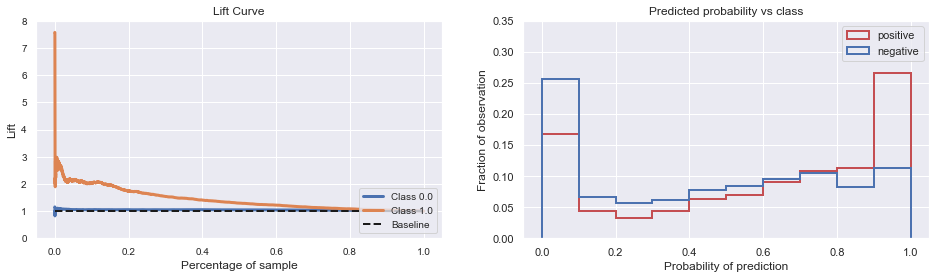

In [119]:
# get liftcurve, probahisto and scores on X_train, y_train for model GaussianNB
liftcurve_probahisto_score(trainmodel_os_cv, GaussianNB(), 'GaussianNB',  5, X_train, y_train, 8, 0.35)

,precison,recall,f1score,roc_auc,positive_in_top20pct,positive_in_top50pct
GaussianNB,0.162,0.617,0.256,0.603,251.0,447.0


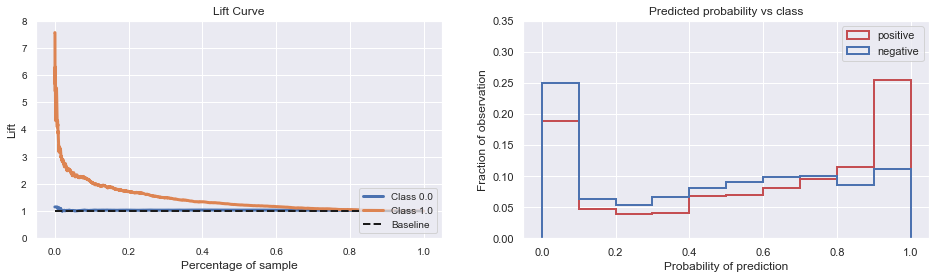

In [120]:
# get liftcurve, probahisto and scores on X_test, y_test for model GaussianNB
liftcurve_probahisto_score(trainmodel_os_cv, GaussianNB(), 'GaussianNB', 5, X_test, y_test, 8, 0.35)

,precison,recall,f1score,roc_auc,positive_in_top20pct,positive_in_top50pct
KNN,0.34,0.833,0.483,0.872,1203.0,1555.0


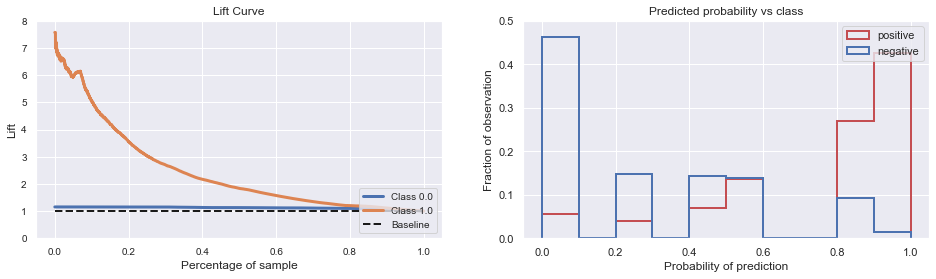

In [1669]:
liftcurve_probahisto_score(KNeighborsClassifier(), 'KNN',  5, X_train, y_train, 8, 0.5)

,precison,recall,f1score,roc_auc,positive_in_top20pct,positive_in_top50pct
KNN,0.166,0.416,0.237,0.565,190.0,420.0


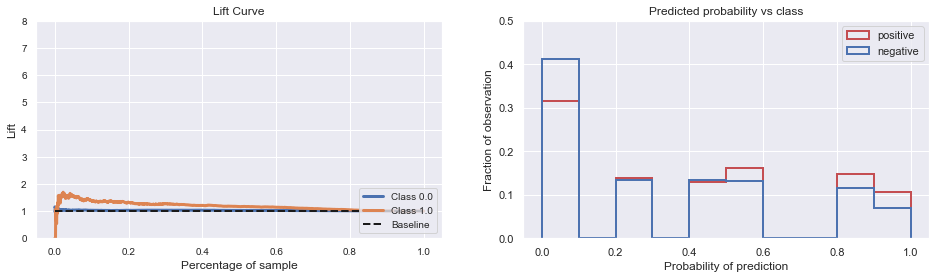

In [1670]:
liftcurve_probahisto_score(KNeighborsClassifier(), 'KNN',  5, X_test, y_test, 8, 0.5)

,precison,recall,f1score,roc_auc,positive_in_top20pct,positive_in_top50pct
DT,0.785,0.837,0.81,0.909,1468.0,1681.0


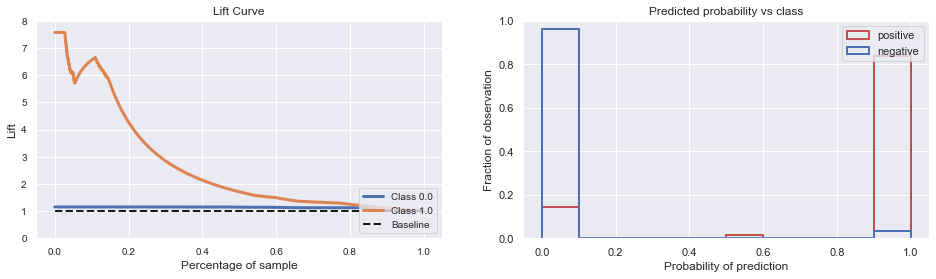

In [1671]:
liftcurve_probahisto_score(DecisionTreeClassifier(random_state=43), 'DT', 5,  X_train, y_train, 8, 1.0)

,precison,recall,f1score,roc_auc,positive_in_top20pct,positive_in_top50pct
DT,0.156,0.209,0.178,0.519,174.0,380.0


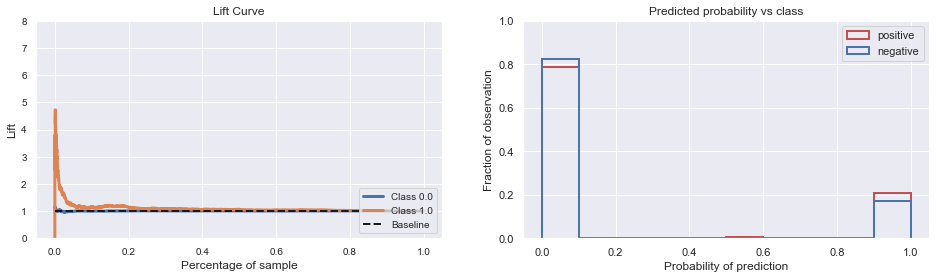

In [1672]:
liftcurve_probahisto_score(DecisionTreeClassifier(random_state=43), 'DT',  5, X_test, y_test, 8, 1.0)

,precison,recall,f1score,roc_auc,positive_in_top20pct,positive_in_top50pct
RF,0.876,0.821,0.848,0.953,1514.0,1639.0


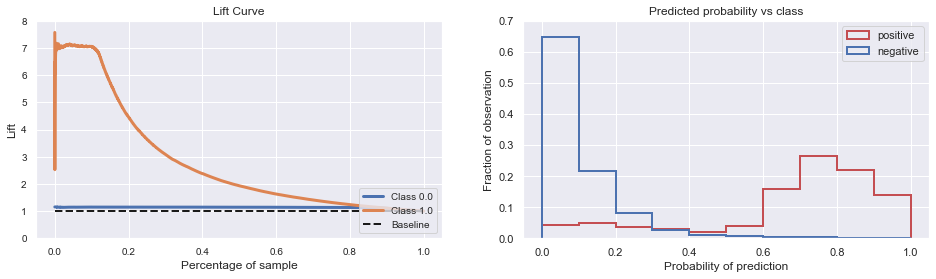

In [1673]:
liftcurve_probahisto_score(RandomForestClassifier(random_state=43), 'RF',  5, X_train, y_train, 8, 0.7)

,precison,recall,f1score,roc_auc,positive_in_top20pct,positive_in_top50pct
RF,0.215,0.139,0.169,0.589,217.0,442.0


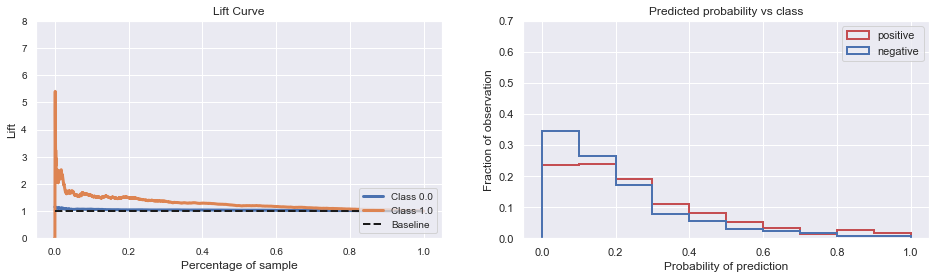

In [1674]:
liftcurve_probahisto_score(RandomForestClassifier(random_state=43), 'RF',  5, X_test, y_test, 8, 0.7)

,precison,recall,f1score,roc_auc,positive_in_top20pct,positive_in_top50pct
GB,0.305,0.132,0.184,0.642,586.0,1150.0


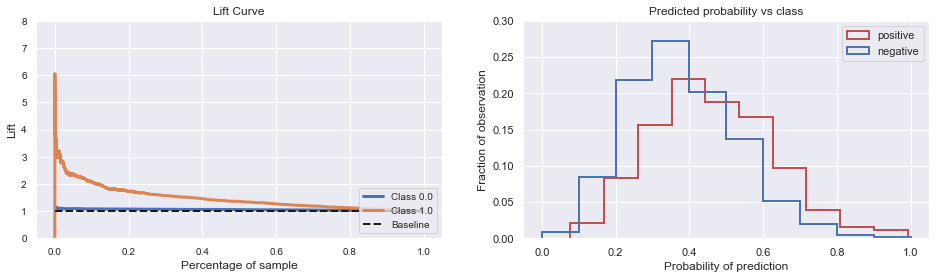

In [1675]:
liftcurve_probahisto_score(GradientBoostingClassifier(random_state=43), 'GB',  5, X_train, y_train, 8, 0.3)

,precison,recall,f1score,roc_auc,positive_in_top20pct,positive_in_top50pct
GB,0.277,0.125,0.172,0.599,235.0,448.0


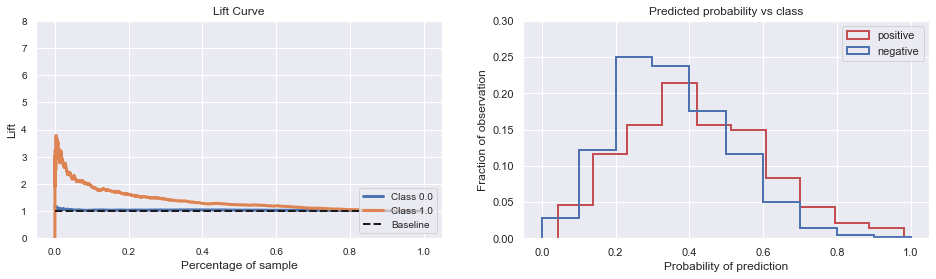

In [1676]:
liftcurve_probahisto_score(GradientBoostingClassifier(random_state=43), 'GB',  5, X_test, y_test, 8, 0.3)

,precison,recall,f1score,roc_auc,positive_in_top20pct,positive_in_top50pct
XGB,0.724,0.207,0.322,0.83,1057.0,1491.0


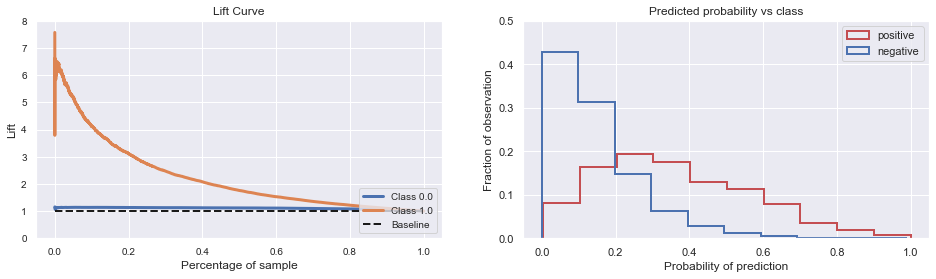

In [1677]:
liftcurve_probahisto_score(XGBClassifier(random_state=43), 'XGB',  5, X_train, y_train, 8, 0.5)

,precison,recall,f1score,roc_auc,positive_in_top20pct,positive_in_top50pct
XGB,0.267,0.065,0.104,0.59,222.0,443.0


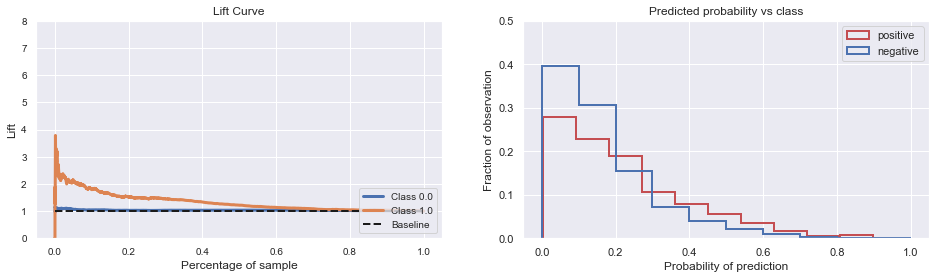

In [1678]:
liftcurve_probahisto_score(XGBClassifier(random_state=43), 'XGB',  5, X_test, y_test, 8, 0.5)

,precison,recall,f1score,roc_auc,positive_in_top20pct,positive_in_top50pct
LightGB,0.484,0.096,0.16,0.755,818.0,1368.0


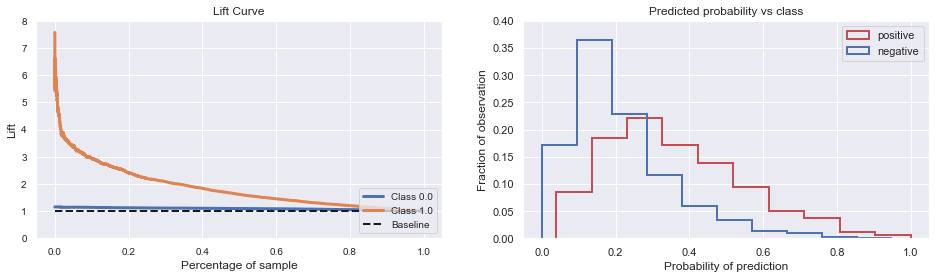

In [1679]:
liftcurve_probahisto_score(lgb.LGBMClassifier(objective='binary',random_state=43), 'LightGB',  5, X_train, y_train, 8, 0.4)

,precison,recall,f1score,roc_auc,positive_in_top20pct,positive_in_top50pct
LightGB,0.361,0.066,0.111,0.603,234.0,455.0


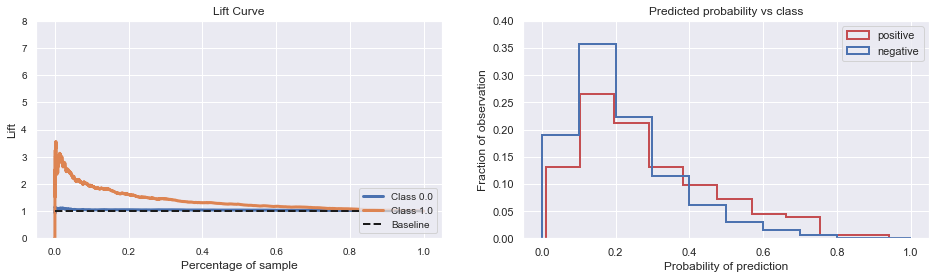

In [1680]:
liftcurve_probahisto_score(lgb.LGBMClassifier(objective='binary',random_state=43), 'LightGB',  5, X_test, y_test, 8, 0.4)

In [1681]:
liftcurve_probahisto_score(SVC(probability=True, random_state=43), 'SVC',  5,  X_train, y_train, 6, 0.3)

KeyboardInterrupt: 

In [ ]:
liftcurve_probahisto_score(SVC(probability=True, random_state=43), 'SVC',  5,  X_test, y_test, 6, 0.3)

In [ ]:
## Check feature importance for model GaussianNB and LogisticRegression

In [ ]:
# check feature importance for LogisticRegression
model = trainmodel_os_cv(LogisticRegression(), X_train, y_train, 5)
len(model.coef_[0])

fig,ax = plt.subplots(figsize=(16,10))
    
plt.barh(df.drop('target',axis=1).columns.tolist(), abs(model.coef_[0]))

In [ ]:
# check feature importance for GaussianNB
from sklearn.inspection import permutation_importance
model = trainmodel_os_cv(GaussianNB(), X_train, y_train, 5)

imps = permutation_importance(model, X_train, y_train)
fig,ax = plt.subplots(figsize=(16,10))
plt.barh(df.drop('target',axis=1).columns.tolist(), abs(imps.importances_mean))
plt.show()

In [ ]:
model = trainmodel_os_cv(GradientBoostingClassifier(random_state=43), X_train, y_train, 5)

fig,ax = plt.subplots(figsize=(16,10))
plt.barh(df.drop('target',axis=1).columns.tolist(), model.feature_importances_)

In [ ]:
# feature importance for lighgbm
from lightgbm import plot_importance
model = trainmodel_os_cv(lgb.LGBMClassifier(objective='binary',random_state=43), X_train, y_train, 5)
fig, ax = plt.subplots(figsize=(16, 10))
plot_importance(model,ax=ax)
plt.show()

In [ ]:
# feature importance for XGB
from xgboost import plot_importance
model = trainmodel_os_cv(XGBClassifier(random_state=43), X_train, y_train, 5)
fig, ax = plt.subplots(figsize=(16, 10))
plot_importance(model,ax=ax)
plt.show()

In [ ]:
model = trainmodel_os_cv(XGBClassifier(random_state=43), X_train, y_train, 5)


y_probas = model.predict_proba(X_test)
skplt.metrics.plot_lift_curve(y_test, y_probas)

In [ ]:

from __future__ import absolute_import
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_breast_cancer as load_data
import scikitplot as skplt


X, y = load_data(return_X_y=True)
lr = LogisticRegression()
lr.fit(X, y)
probas = lr.predict_proba(X)
skplt.metrics.plot_lift_curve(y_true=y, y_probas=probas)
plt.show()

In [ ]:
y.shape